In [2]:
# @title #### Student Identity
student_id = "REAJN7WZ" # @param {type:"string"}
name = "Reyhan Wiranugraha" # @param {type:"string"}
drive_link = "https://drive.google.com/drive/u/0/folders/1uhnn6SaQQmo0dwiYPQqYUtKeQu26mz9K"  # @param {type:"string"}

assignment_id = "00_cnn_project"

In [3]:
!pip install rggrader
from rggrader import submit, submit_image

!pip install wandb
import wandb

In [6]:
# All required package/module
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision.datasets import ImageFolder
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from PIL import Image

# from google.colab import drive
# drive.mount('/content/drive')

import os
import random
import shutil
import wandb
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
!pip install timm
import timm

## Task-1 Load the dataset


### I. RealWaste Image Classification

About Dataset
Overview

An image classification dataset of waste items across 12 major material types, collected within an authentic landfill environment.

dataset source:
https://www.kaggle.com/datasets/reyhanwiranugraha/real-image-dataset/data

Because of the dataset content only have images with it classes, now i want to getting CSV file from image dataset

In [5]:
# datasets/
# ├── set/
# │    ├── Cardboard/
# │    │    ├── image1.jpg
# │    │    ├── image2.jpg
# │    │    └── ...
# │    ├── Food Organics/
# │    │    ├── image1.jpg
# │    │    ├── image2.jpg
# │    │    └── ...
# │    ├── Glass/
# │    │    ├── image1.jpg
# │    │    ├── image2.jpg
# │    │    └── ...
# │    ├── Metal/
# │    │    ├── image1.jpg
# │    │    ├── image2.jpg
# │    │    └── ...
# │    ├── Miscellaneous Trash/
# │    │    ├── image1.jpg
# │    │    ├── image2.jpg
# │    │    └── ...
# │    ├── Paper/
# │    │    ├── image1.jpg
# │    │    ├── image2.jpg
# │    │    └── ...
# │    ├── Plastic/
# │    │    ├── image1.jpg
# │    │    ├── image2.jpg
# │    │    └── ...
# │    ├── Textile Trash/
# │    │    ├── image1.jpg
# │    │    ├── image2.jpg
# │    │    └── ...
# │    ├── Vegetation/
# │    │    ├── image1.jpg
# │    │    ├── image2.jpg
# │    │    └── ...

# Root directory containing the dataset
# root_dir = '/content/drive/MyDrive/Colab Notebooks/Bootcamp/Project/Project_08/datasets'  # Update with your dataset directory
root_dir = "datasets/train" 

#----------------------------------------------------------------- Dataset Rebalance -----------------------------------------------------------------
# Dictionary to store image counts per class
class_counts = {}

# Iterate through each class directory
for class_name in os.listdir(root_dir):
    class_dir = os.path.join(root_dir, class_name)
    if os.path.isdir(class_dir):
        # Count the number of images in each class directory
        class_counts[class_name] = len(os.listdir(class_dir))

# Find the maximum count (majority class count)
max_count = max(class_counts.values())

# Directory to store the rebalanced dataset
output_dir = "datasets/balanced_train"
os.makedirs(output_dir, exist_ok=True)

# Iterate through each class directory again
for class_name, count in class_counts.items():
    class_dir = os.path.join(root_dir, class_name)
    
    # Calculate how many additional images are needed for this class
    num_additional_images = max_count - count
    
    # If class is underrepresented, augment it by randomly sampling existing images
    if num_additional_images > 0:
        # Create a directory for the balanced class
        balanced_class_dir = os.path.join(output_dir, class_name)
        os.makedirs(balanced_class_dir, exist_ok=True)
        
        # List all images in the original class directory
        images = os.listdir(class_dir)
        
        # Randomly sample images with replacement to achieve balance
        for i in range(num_additional_images):
            random_image = random.choice(images)
            source_path = os.path.join(class_dir, random_image)
            target_path = os.path.join(balanced_class_dir, f"{random_image.split('.')[0]}_{i}.{random_image.split('.')[-1]}")
            shutil.copy(source_path, target_path)
    
    # If class is already balanced, simply copy images to the output directory
    else:
        shutil.copytree(class_dir, os.path.join(output_dir, class_name))

#----------------------------------------------------------------- create a DataFrame with file paths and labels -----------------------------------------------------------------
# Now that the dataset is rebalanced, let's create a DataFrame with file paths and labels
root_dir = "datasets"
# Get the list of classes (subfolders) in the set image folder
classes = os.listdir(os.path.join(root_dir, "balanced"))

# Initialize lists to store file paths and labels
file_paths = []
labels = []

# Initialize a counter for the total number of images
train_images = 0

# Iterate over each class directory
for class_name in classes:
    class_dir_train = os.path.join(root_dir, "balanced", class_name)


    # Get the list of image files in the train and test class directories
    images_train = os.listdir(class_dir_train)

    # Add train file paths and labels
    for image_train in images_train:
        file_paths.append(os.path.join("balanced_train", class_name, image_train))
        labels.append(class_name)

    # Update the total number of images
    train_images += len(images_train)

# Create a DataFrame with file paths and labels
df = pd.DataFrame({
    'file_path': file_paths,
    'label': labels
})

# Save the DataFrame to a CSV file
df.to_csv("balanced_dataset.csv", index=False)

print("Dataset rebalanced successfully!")
print(f"Total number of images in datasets/: {train_images}")
print("CSV file created successfully.")


Dataset rebalanced successfully!
Total number of images in datasets/: 18086
CSV file created successfully.


### I.1 Dataset Preview
Now we want to display a couple of images from the seg_train dataset.

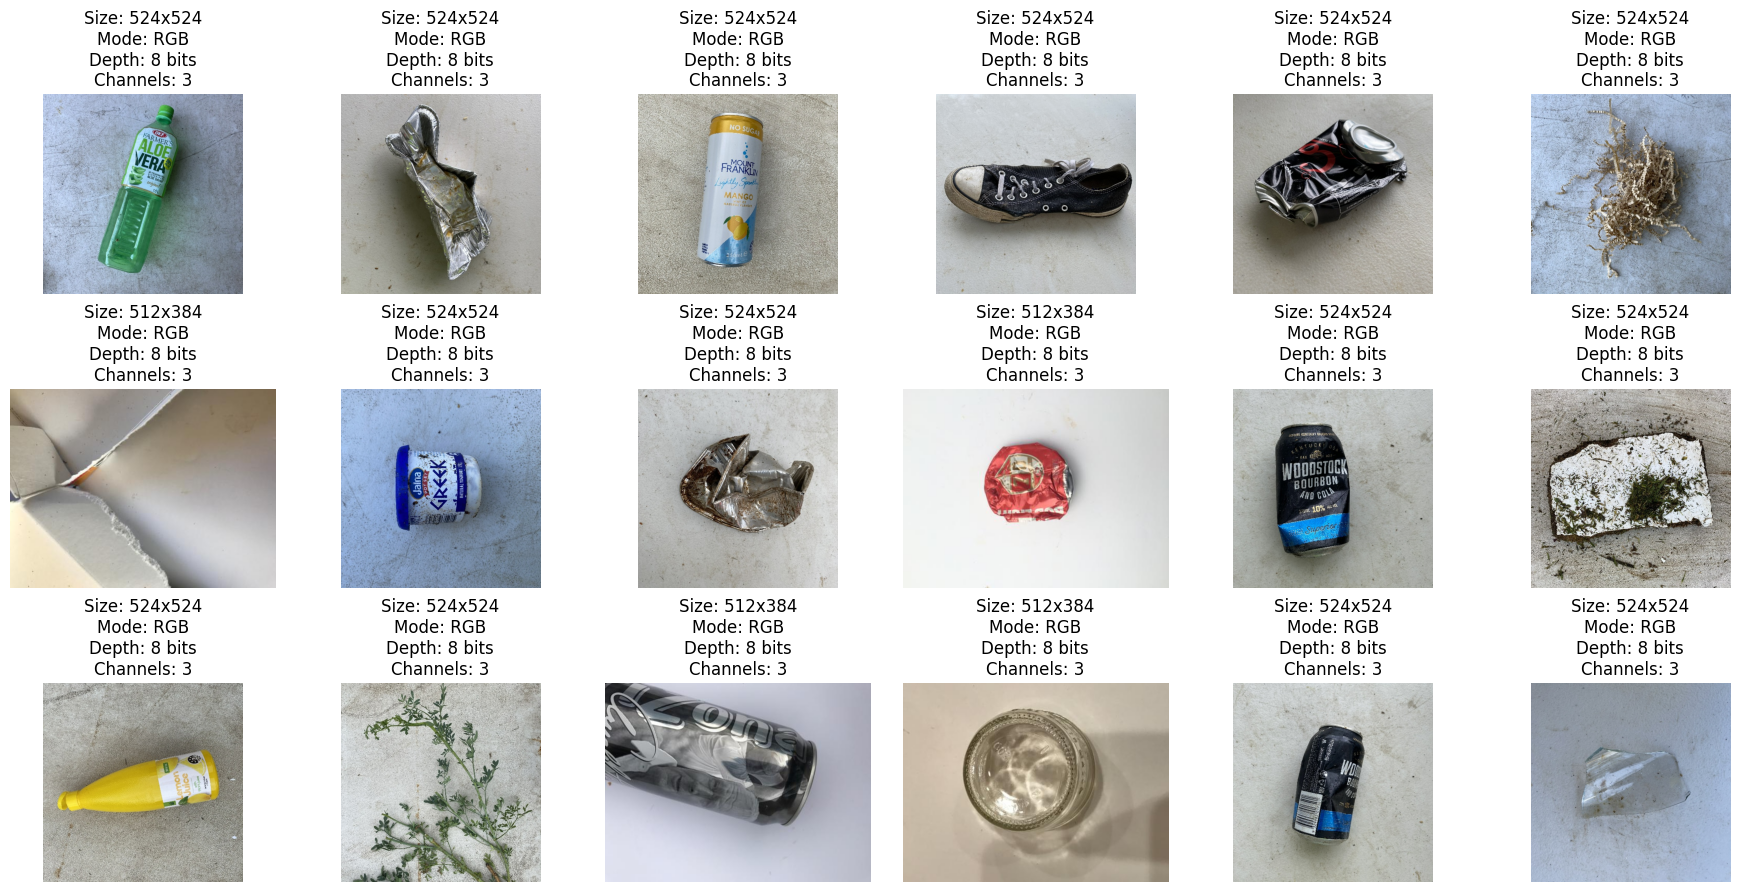

In [ ]:
# Path to the training image folder
train_image_folder = '/content/drive/MyDrive/Colab Notebooks/Bootcamp/Project/Project_08/datasets/train'  # Update with your dataset directory
os.chdir(train_image_folder)

# Get list of image files in the training image folder
image_files = []
for class_name in os.listdir(train_image_folder):
    class_dir = os.path.join(train_image_folder, class_name)
    if os.path.isdir(class_dir):
        image_files.extend([os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith('.jpg')])  # Filter only image files

# Sample 18 random images
sample_images = np.random.choice(image_files, 18, replace=False)

# Plot the sample images along with their properties
fig, axes = plt.subplots(3, 6, figsize=(18, 9))
for i, (ax, image_path) in enumerate(zip(axes.flat, sample_images)):
    # Open the image using PIL
    img = Image.open(image_path)
    # Get image properties
    width, height = img.size
    mode = img.mode  # Color mode (e.g., RGB, grayscale)
    depth = img.bits  # Depth of the image (bits per pixel)
    channels = len(img.getbands())  # Number of color channels

    # Display the image
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Size: {width}x{height}\nMode: {mode}\nDepth: {depth} bits\nChannels: {channels}")

plt.tight_layout()
plt.show()

Hmm... Looks good, we can smell the picture from here :D

In [ ]:
import pandas as pd

# Load the CSV file into a pandas DataFrame
# Replace "dataset.csv" with the actual filename of your CSV file
df = pd.read_csv("dataset.csv")

# Print the first few rows of the DataFrame
print(df.head())

# Accessing the data
file_paths = df['file_path']
labels = df['label']

                        file_path      label
0    set\Cardboard\cardboard1.jpg  Cardboard
1   set\Cardboard\cardboard10.jpg  Cardboard
2  set\Cardboard\cardboard100.jpg  Cardboard
3  set\Cardboard\cardboard101.jpg  Cardboard
4  set\Cardboard\cardboard102.jpg  Cardboard


In [ ]:
# # Path to the main dataset directory
# dataset_dir = "datasets/set"  # Update with your dataset directory

# # List all class directories
# class_dirs = [os.path.join(dataset_dir, class_name) for class_name in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, class_name))]

# # Split each class directory into train and test directories
# train_dir = "datasets/train"
# test_dir = "datasets/test"
# for class_dir in class_dirs:
#     # Create train and test directories for the class
#     train_class_dir = os.path.join(train_dir, os.path.basename(class_dir))
#     test_class_dir = os.path.join(test_dir, os.path.basename(class_dir))
#     os.makedirs(train_class_dir, exist_ok=True)
#     os.makedirs(test_class_dir, exist_ok=True)

#     # Split images for the class into train and test sets
#     class_files = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
#     train_files, test_files = train_test_split(class_files, test_size=0.2, random_state=42)

#     # Move files to train and test directories
#     for file in train_files:
#         shutil.move(file, os.path.join(train_class_dir, os.path.basename(file)))

#     for file in test_files:
#         shutil.move(file, os.path.join(test_class_dir, os.path.basename(file)))

In [ ]:
# Root directory containing the dataset
dataset_dir = './datasets'
os.chdir(dataset_dir)

# Get the list of classes (subfolders) in the training image folder
classes = os.listdir(os.path.join(dataset_dir, "train"))

# Initialize lists to store file paths and labels
file_paths = []
labels = []

# Initialize a counter for the total number of images
train_images = 0
test_images = 0
total_images = 0

# Iterate over each class directory
for class_name in classes:
    class_dir_train = os.path.join(dataset_dir, "train", class_name)
    class_dir_test = os.path.join(dataset_dir, "test", class_name)

    # Get the list of image files in the train and test class directories
    images_train = os.listdir(class_dir_train)
    images_test = os.listdir(class_dir_test)

    # Add train file paths and labels
    for image_train in images_train:
        file_paths.append(os.path.join("train", class_name, image_train))
        labels.append(class_name)

    # Add test file paths and labels
    for image_test in images_test:
        file_paths.append(os.path.join("test", class_name, image_test))
        labels.append(class_name)

    # Update the total number of images
    train_images += len(images_train)
    test_images += len(images_test)
    total_images += len(images_train) + len(images_test)

# Create a DataFrame with file paths and labels
df = pd.DataFrame({
    'file_path': file_paths,
    'label': labels
})

# Save the DataFrame to a CSV file
df.to_csv("dataset.csv", index=False)

print(f"Total number of images in datasets/train: {train_images}")
print(f"Total number of images in datasets/test: {test_images}")
print(f"Total number of images in datasets: {total_images}")
print("CSV file created successfully.")

### 1.2 Submission

You'll submit the link to your dataset for Task-1.

- If you use existing dataset from Kaggle or Huggingface, then you can put the link to those dataset here.

- If you use your own custom dataset, Upload and store the custom dataset in your Google Drive that you shared with us and put the link to the folder containing that dataset here.

In [ ]:
# Submit Method
dataset_link = "https://www.kaggle.com/datasets/reyhanwiranugraha/real-image-dataset/data" # Put your model link

question_id = "00_cnn_project_dataset"
submit(student_id, name, assignment_id, dataset_link, question_id, drive_link)

'Assignment successfully submitted'

## Task-2 Build a model

In this task, you will now build and save your model. You can either create your own CNN model or choose any pretrained model that you feel is most appropriate for your dataset.

### 2.1 Write your code in the block below

In the code block below, write the code to **create your model, either from scratch or fine tuning a pretrained model**. You will need to write the code for your model definition, such as the layers used, loss function and optimizer. Please include also the training and validation loops.

Make sure you **save your model to a file** and **measure the accuracy of your model**, as this will be submitted for this task.

Some techniques you may use:
- Use pretrained model. (Easy)
- Create a CNN model from scratch. (Hard)
- Etc.

Hint:
- Use GPU in Google Colab, it significantly improves the time taken for training, compared to CPU.
- **Google Colab GPU usage for free-tier have a limit**, which is unknown, so I suggest you try out in CPU mode that your code works without error, then use GPU for traininig.
- If you are going to upload to Huggingface by using the Transformer Trainer during training, make sure you use the Huggingface method. Refer to Transfer Learning section or read the documentation here: https://huggingface.co/docs/transformers/model_sharing

In [ ]:
# Path to the main dataset directory
dataset_dir = "datasets/set"  # Update with your dataset directory

# List all class directories
class_dirs = [os.path.join(dataset_dir, class_name) for class_name in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, class_name))]

# Split each class directory into train and test directories
train_dir = "datasets/train"
test_dir = "datasets/test"
for class_dir in class_dirs:
    # Create train and test directories for the class
    train_class_dir = os.path.join(train_dir, os.path.basename(class_dir))
    test_class_dir = os.path.join(test_dir, os.path.basename(class_dir))
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    # Split images for the class into train and test sets
    class_files = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
    train_files, test_files = train_test_split(class_files, test_size=0.2, random_state=42)

    # Move files to train and test directories
    for file in train_files:
        shutil.move(file, os.path.join(train_class_dir, os.path.basename(file)))

    for file in test_files:
        shutil.move(file, os.path.join(test_class_dir, os.path.basename(file)))

### 2.1a My Own CNN Model

In [4]:
!pip install efficientnet-pytorch
from efficientnet_pytorch import EfficientNet

In [ ]:
# Define your custom augmentation function
def custom_augmentation(image):
    # Implement your custom augmentation logic here
    # For example, you can apply random flips, rotations, etc.
    return image

# Create a transform using transform v2
transform = transforms.Compose([
    # Convert PIL Image to PyTorch tensor
    transforms.ToTensor(),
    # Apply your custom augmentation function
    transforms.Lambda(lambda x: custom_augmentation(x)),
    # Other standard transformations
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
])

# Load an example image
image_path = "path/to/your/image.jpg"
image = Image.open(image_path)

# Apply the transformations
transformed_image = transform(image)

# Display the original and transformed images (optional)
image.show(title="Original Image")
transformed_image_pil = F.to_pil_image(transformed_image)
transformed_image_pil.show(title="Transformed Image")

# Convert the transformed image to a PyTorch tensor
transformed_image_tensor = transforms.ToTensor()(transformed_image)

In [5]:
# Define data transformations and create dataloaders
train_transform = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.RandomResizedCrop(244),   # Randomly crop images to 244x244
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),       # Randomly rotate images by 10 degrees
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),  # Randomly shear and scale images
    transforms.ToTensor(),            # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize pixel values
])

test_transform = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create a dataset from the image folder
train_data = ImageFolder(root="datasets/train", transform=train_transform)
test_data = ImageFolder(root="datasets/test", transform=test_transform)

# Print image sizes in the test loader
for inputs, labels in test_data:
    print(inputs.size(), labels)

# Create a DataLoader with the defined transformations
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 244]) 0
torch.Size([3, 244, 

compute the class frequencies

In [ ]:
# Compute class weights
class_counts = [train_data.targets.count(c) for c in range(len(train_data.classes))]
total_samples = sum(class_counts)
class_weights = [total_samples / (len(train_data.classes) * count) for count in class_counts]

# Create a sampler with class weights
weights = [class_weights[label] for label in train_data.targets]
sampler = WeightedRandomSampler(weights=weights, num_samples=len(train_data), replacement=True)

# Create DataLoader with the custom sampler
train_data_gen = DataLoader(train_data, batch_size=32, sampler=sampler)

In [7]:
# Initialize WandB with existing project
wandb.init(project="real-waste-project", entity="eunoiawiira")

def log_image_table(inputs, predicted, labels, probs):
    "Log a wandb.Table with (img, pred, target, scores)"
    # 🐝 Create a wandb Table to log images, labels and predictions to
    table = wandb.Table(columns=["inputs", "pred", "target"]+[f"score_{i}" for i in range(10)])
    for img, pred, targ, prob in zip(inputs.to("cpu"), predicted.to("cpu"), labels.to("cpu"), probs.to("cpu")):
        table.add_data(wandb.Image(img[0].numpy()*255), pred, targ, *prob.numpy())
    wandb.log({"predictions_table":table}, commit=False)

# Define the random seed
RS = 42  # You can choose any integer value for the seed

# Set random seed for reproducibility
torch.manual_seed(RS)
np.random.seed(RS)

# Load the EfficientNetV2-Small model from timm
class EfficientNetV2Small(nn.Module):
    def __init__(self, num_classes=1000):
        super(EfficientNetV2Small, self).__init__()
        self.model = timm.create_model('efficientnetv2_m', pretrained=False)
        self.model.classifier = nn.Linear(self.model.classifier.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Create an instance of the model
model = EfficientNetV2Small(num_classes=1000)

# Create an instance of your EfficientNet model
num_classes = 12  # Example: adjust based on the number of classes in your dataset
model = EfficientNetV2Small(num_classes)
print(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Log model to WandB
wandb.watch(model)

# Initialize the scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Example parameters

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for step, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        # Step the scheduler
        scheduler.step()

        if (step+1) % 10 == 0:
            wandb.log({"Train Loss": loss.item()})
        if (step+1) % 10 == 0:  # Print every 10 steps
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{step+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(test_data)
    accuracy = correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.4f}")
    wandb.log({"Validation Loss": val_loss, "Validation Accuracy": accuracy})
    # Log predictions table periodically
    if total % 100 == 0:
      probabilities = torch.softmax(outputs, dim=1)
      log_image_table(inputs, predicted, labels, probabilities)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy}")
    wandb.log({"Test Accuracy": accuracy})

    
# # Make predictions
# pred_test = []
# with torch.no_grad():
#     for inputs, _ in test_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1)
#         pred_test.extend(predicted.tolist())

# # Compute confusion matrix and accuracy
# from sklearn.metrics import confusion_matrix, accuracy_score
# true_labels = [label.item() for _, label in test_data]
# cm = confusion_matrix(true_labels, pred_test)
# acc = accuracy_score(true_labels, pred_test)
# print("Confusion Matrix:")
# print(cm)
# print("Accuracy:", acc)

# Save the model
model_path = "eunoiawiira_efficientNet_finetuned_realwaste.pth"
torch.save(model.state_dict(), model_path)

# 🐝 Close your wandb run
wandb.finish()

Test Accuracy,▂▁█
Train Loss,▅▇▅▄▃▄▆▆▄▆▅▇▅▄▄▃▅▄▅▆▆▆▄▅▃▅▂▃▃▆▁▇█▇▃▄▄▇▃▃
Validation Accuracy,▂▁█
Validation Loss,▂█▁
Test Accuracy,0.24125
Train Loss,2.34624
Validation Accuracy,0.24125
Validation Loss,2.50788


EfficientNetV2Small(
  (model): EfficientNet(
    (conv_stem): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
        (1): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inpl

KeyboardInterrupt: 

### 2.1b Fine-tuning VGG as CNN Model

In [16]:
# Define data transformations for training and testing
train_transform = transforms.Compose([
    transforms.Resize(299),  # Resize to a slightly larger size
    transforms.RandomResizedCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize(350),  # Resize to a slightly larger size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [17]:
# Initialize WandB with existing project
wandb.init(project="real-waste-project", entity="eunoiawiira")

def log_image_table(inputs, predicted, labels, probs):
    "Log a wandb.Table with (img, pred, target, scores)"
    # 🐝 Create a wandb Table to log images, labels and predictions to
    table = wandb.Table(columns=["inputs", "pred", "target"]+[f"score_{i}" for i in range(10)])
    for img, pred, targ, prob in zip(inputs.to("cpu"), predicted.to("cpu"), labels.to("cpu"), probs.to("cpu")):
        table.add_data(wandb.Image(img[0].numpy()*255), pred, targ, *prob.numpy())
    wandb.log({"predictions_table":table}, commit=False)

# Load dataset with data augmentation for training and without augmentation for testing
train_data = ImageFolder(root='/content/drive/My Drive/Colab Notebooks/Bootcamp/Project/Project_08/datasets/train', transform=train_transform)
test_data = ImageFolder(root='/content/drive/My Drive/Colab Notebooks/Bootcamp/Project/Project_08/datasets/test', transform=test_transform)

# Define dataloaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Define the VGG11 model
class VGG11(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG11, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Create an instance of the VGG13 model
num_classes = 12  # Adjust based on the number of classes in your dataset
model = VGG11(num_classes)

# Print the model architecture
print(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Log model to WandB
wandb.watch(model)

# Initialize the scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Example parameters

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for step, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        # Step the scheduler
        scheduler.step()

        if (step+1) % 10 == 0:
            wandb.log({"Train Loss": loss.item()})
        if (step+1) % 10 == 0:  # Print every 10 steps
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{step+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(test_data)
    accuracy = correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.4f}")
    wandb.log({"Validation Loss": val_loss, "Validation Accuracy": accuracy})
    # Log predictions table periodically
    if total % 100 == 0:
      probabilities = torch.softmax(outputs, dim=1)
      log_image_table(inputs, predicted, labels, probabilities)


# Save the model
model_path = "eunoiawiira_vgg11_finetuned.pth"
torch.save(model.state_dict(), model_path)

# 🐝 Close your wandb run
wandb.finish()

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/drive/My Drive/Colab Notebooks/Bootcamp/Project/Project_08/datasets/train'

In [ ]:
# Submit Method
model_link = "https://drive.google.com/file/d/19OfH0mJCo7AAutotlukPEqtxxQDZBqkU/view?usp=sharing" # Put your model link

question_id = "01_cnn_project_model_link"
submit(student_id, name, assignment_id, model_link, question_id, drive_link)
question_id = "02_cnn_project_model_accuracy"
submit(student_id, name, assignment_id, str(accuracy), question_id, drive_link)

'Assignment successfully submitted'

### 2.1c Fine-tuning InceptionV3 as CNN Model

In [6]:
# Define data transformations for training and testing
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [10]:
# Initialize WandB with existing project
wandb.init(project="real-waste-project", entity="eunoiawiira")

def log_image_table(inputs, predicted, labels, probs):
    "Log a wandb.Table with (img, pred, target, scores)"
    # 🐝 Create a wandb Table to log images, labels and predictions to
    table = wandb.Table(columns=["inputs", "pred", "target"]+[f"score_{i}" for i in range(10)])
    for img, pred, targ, prob in zip(inputs.to("cpu"), predicted.to("cpu"), labels.to("cpu"), probs.to("cpu")):
        table.add_data(wandb.Image(img[0].numpy()*255), pred, targ, *prob.numpy())
    wandb.log({"predictions_table":table}, commit=False)

# Create a dataset from the image folder
train_data = ImageFolder(root="datasets/train", transform=train_transform)
test_data = ImageFolder(root="datasets/test", transform=test_transform)

# Define dataloaders
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False)

# Define the Model
class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_pool):
        super(InceptionModule, self).__init__()
        
        # 1x1 convolution branch
        self.conv1x1 = nn.Conv2d(in_channels, out_1x1, kernel_size=1)
        
        # 3x3 convolution branch
        self.conv3x3_reduce = nn.Conv2d(in_channels, red_3x3, kernel_size=1)
        self.conv3x3 = nn.Conv2d(red_3x3, out_3x3, kernel_size=3, padding=1)
        
        # 5x5 convolution branch
        self.conv5x5_reduce = nn.Conv2d(in_channels, red_5x5, kernel_size=1)
        self.conv5x5 = nn.Conv2d(red_5x5, out_5x5, kernel_size=5, padding=2)
        
        # Max pooling branch
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.conv_pool = nn.Conv2d(in_channels, out_pool, kernel_size=1)
        
    def forward(self, x):
        branch1x1 = F.relu(self.conv1x1(x))
        
        branch3x3 = F.relu(self.conv3x3_reduce(x))
        branch3x3 = F.relu(self.conv3x3(branch3x3))
        
        branch5x5 = F.relu(self.conv5x5_reduce(x))
        branch5x5 = F.relu(self.conv5x5(branch5x5))
        
        branch_pool = F.relu(self.conv_pool(self.maxpool(x)))
        
        # Concatenate the outputs of all branches along the channel dimension
        output = torch.cat([branch1x1, branch3x3, branch5x5, branch_pool], dim=1)
        
        return output

class InceptionV3(nn.Module):
    def __init__(self, num_classes=12):
        super(InceptionV3, self).__init__()
        
        # Initial layers before inception modules
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Inception modules
        self.inception1 = InceptionModule(64, 64, 96, 128, 16, 32, 32)
        self.inception2 = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.inception3 = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        
        # Additional inception module
        self.inception4 = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        
        # Fully connected layer
        self.fc = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.inception3(x)
        x = self.inception4(x)
        
        # Global average pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        
        # Fully connected layer
        x = self.fc(x)
        
        return F.softmax(x, dim=1)

# Create an instance of the VGG13 model
num_classes = 12  # Adjust based on the number of classes in your dataset
model = InceptionV3(num_classes)

# Print the model architecture
print(model)

# Input tensor dimensions for verification
sample_input = torch.randn(8, 3, 299, 299)  # Batch size, channels, height, width
output = model(sample_input)
print("Output shape:", output.shape)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Log model to WandB
wandb.watch(model)

# Initialize the scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Example parameters

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for step, (inputs, labels) in enumerate(train_loader):
        print("Input image size:", inputs.size())
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        if (step+1) % 10 == 0:
            wandb.log({"Train Loss": loss.item()})
        if (step+1) % 10 == 0:  # Print every 10 steps
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{step+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}")

    # Step the scheduler
    scheduler.step()

    epoch_loss = running_loss / len(train_data)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}")
    wandb.log({"Epoch": epoch+1, "Train Loss": epoch_loss})

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(test_data)
    accuracy = correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.4f}")
    wandb.log({"Validation Loss": val_loss, "Validation Accuracy": accuracy})
    # Log predictions table periodically
    if total % 100 == 0:
      probabilities = torch.softmax(outputs, dim=1)
      log_image_table(inputs, predicted, labels, probabilities)


# Save the model
model_path = "eunoiawiira_inceptionv3_finetuned_waste.pth"
torch.save(model.state_dict(), model_path)

# 🐝 Close your wandb run
wandb.finish()

InceptionV3(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (inception1): InceptionModule(
    (conv1x1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (conv3x3_reduce): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1))
    (conv3x3): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5x5_reduce): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    (conv5x5): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (maxpool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (conv_pool): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (inception2): InceptionModule(
    (conv1x1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (conv3x3_reduce): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (conv3x3): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

Submit

In [ ]:
# Submit Method
model_link = "https://drive.google.com/file/d/1lp1o9tbiLNF0ig8uu_lx2MjZltapXfF7/view?usp=sharing" # Put your model link

question_id = "01_cnn_project_model_link"
submit(student_id, name, assignment_id, model_link, question_id, drive_link)
question_id = "02_cnn_project_model_accuracy"
submit(student_id, name, assignment_id, str(accuracy), question_id, drive_link)

### 2.1d Fine-tuning Xception as CNN Model

In [8]:
# Define transformations and augmentations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [13]:
# Initialize WandB with existing project
wandb.init(project="real-waste-project", entity="eunoiawiira")

def log_image_table(inputs, predicted, labels, probs):
    "Log a wandb.Table with (img, pred, target, scores)"
    # 🐝 Create a wandb Table to log images, labels and predictions to
    table = wandb.Table(columns=["inputs", "pred", "target"]+[f"score_{i}" for i in range(10)])
    for img, pred, targ, prob in zip(inputs.to("cpu"), predicted.to("cpu"), labels.to("cpu"), probs.to("cpu")):
        table.add_data(wandb.Image(img[0].numpy()*255), pred, targ, *prob.numpy())
    wandb.log({"predictions_table":table}, commit=False)

# Load dataset with data augmentation for training and without augmentation for testing
train_data = ImageFolder(root="datasets/train", transform=transform)
test_data = ImageFolder(root="datasets/test", transform=transform)

# Define dataloaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, 1, 1, bias=False)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class XceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(XceptionBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 1, stride, 0, bias=False)
        self.sep_conv2 = SeparableConv2d(out_channels, out_channels, 3, 1, 1)
        self.sep_conv3 = SeparableConv2d(out_channels, out_channels, 3, 1, 1)
        self.relu = nn.ReLU(inplace=True)
        self.residual = nn.Conv2d(in_channels, out_channels, 1, stride, 0, bias=False)
        self.shortcut = nn.Sequential()

    def forward(self, x):
        residual = self.residual(x)
        x = self.conv1(x)
        x = self.sep_conv2(x)
        x = self.sep_conv3(x)
        x += residual
        x = self.relu(x)
        return x

class Xception(nn.Module):
    def __init__(self, num_classes=12):
        super(Xception, self).__init__()

        # Entry flow
        self.conv1 = nn.Conv2d(3, 32, 3, 2, 0, bias=False)
        self.conv2 = nn.Conv2d(32, 64, 3, bias=False)
        self.block1 = XceptionBlock(64, 128, 2)
        self.block2 = XceptionBlock(128, 256)
        self.block3 = XceptionBlock(256, 728)
        # ... Add more Xception blocks as needed ...

        # Middle flow
        self.block4 = XceptionBlock(728, 728)
        self.block5 = XceptionBlock(728, 728)
        self.block6 = XceptionBlock(728, 728)
        # ... Add more Xception blocks as needed ...

        # Exit flow
        self.block7 = XceptionBlock(728, 728)
        self.block8 = XceptionBlock(728, 1024, 2)
        self.block9 = XceptionBlock(1024, 1536)
        self.block10 = XceptionBlock(1536, 2048)
        # ... Add more Xception blocks as needed ...

        self.global_pooling = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.global_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Create an instance of the deeper Xception model
model = Xception()
print(model)

# Create an instance of the Xception model
model = Xception()
print(model)

# Create an instance of the Xception model
model = Xception(num_classes=12)

# Print the model architecture
print(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Log model to WandB
wandb.watch(model)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for step, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        if (step+1) % 10 == 0:
            wandb.log({"Train Loss": loss.item()})
        if (step+1) % 10 == 0:  # Print every 10 steps
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{step+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}")

    # Step the scheduler
    scheduler.step()

    epoch_loss = running_loss / len(train_data)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}")
    wandb.log({"Epoch": epoch+1, "Train Loss": epoch_loss})

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(test_data)
    accuracy = correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.4f}")
    wandb.log({"Validation Loss": val_loss, "Validation Accuracy": accuracy})
    # Log predictions table periodically
    if total % 100 == 0:
      probabilities = torch.softmax(outputs, dim=1)
      log_image_table(inputs, predicted, labels, probabilities)


# Save the model
model_path = "eunoiawiira_xception_finetuned.pth"
torch.save(model.state_dict(), model_path)

# 🐝 Close your wandb run
wandb.finish()

wandb: Currently logged in as: eunoiawiira. Use `wandb login --relogin` to force relogin


Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (block1): XceptionBlock(
    (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (sep_conv2): SeparableConv2d(
      (depthwise): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128, bias=False)
      (pointwise): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (sep_conv3): SeparableConv2d(
      (depthwise): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128, bias=False)
      (pointwise): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (relu): ReLU(inplace=True)
    (residual): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (shortcut): Sequential()
  )
  (block2): XceptionBlock(
    (conv1): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (sep_conv2): SeparableC

OutOfMemoryError: CUDA out of memory. Tried to allocate 538.00 MiB. GPU 0 has a total capacty of 6.00 GiB of which 0 bytes is free. Of the allocated memory 11.83 GiB is allocated by PyTorch, and 504.91 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Task-3 Model Inference

In this task, you will be exercising the application of your model, or as it's commonly referred to in AI terminology, you will be performing inference using your model.

Simply load your saved model from Task-2 and create an inference for the model. Where you'll feed an image as input and the model will output the label as well as the percentage of confidence for the label.

### 3.1 Write your code in the block below

In the code block below write the code to use the model you created in Task-2. Load the model and input image, afterwards, show the result of the label/class together with confidence level in percentage as well as the input image.

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

# Load the saved model
model = models.vgg16(pretrained=False)
model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, num_classes)
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/Bootcamp/Project/Project_08/resnet18_finetuned.pth'))
model.eval()

# Define transformations for input image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Function to perform inference
def predict(image_path, model, transform):
    # Open and preprocess the image
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Perform inference
    with torch.no_grad():
        output = model(image)
        probabilities = torch.softmax(output, dim=1)[0]

    # Get predicted label and confidence score
    confidence, predicted_class = torch.max(probabilities, 0)
    predicted_label = train_data.classes[predicted_class.item()]

    # Convert confidence score to percentage
    confidence_percentage = confidence.item() * 100

    return predicted_label, confidence_percentage

# Load and display the input image with its predicted label and confidence score
image_path = "wikipedia_can.jpg"
predicted_label, confidence_percentage = predict(image_path, model, transform)
image = Image.open(image_path)
plt.imshow(image)
plt.axis("off")
plt.title((f"Predicted Class: {predicted_label}, Confidence: {confidence_percentage:.2f}%"))
plt.show()


In [ ]:
# Submit Method

question_id = "03_cnn_project_inference"
submit_image(student_id, question_id, './submission.jpg')

'Assignment successfully submitted'

## Task-4 Model Publishing

In this task, you will push your model to Huggingface. Once you've pushed your model to the Hugging Face Model Hub, you'll have a link that points directly to your model's page. You can share this link with others, and they can use it to directly load your model for their own uses.

### 4.1 Write your code in the block below

In the code block below, write the code to push your model to Huggingface. There are several methods to do this, please refer to the documentation: https://huggingface.co/docs/transformers/model_sharing

Some techniques you may use:
- If you use the Transformer Trainer during the training loop when you create your model above, then you can simply put your `trainer.push_to_hub()` here.
- You can also use the web interface on Huggingface.

Hint:
- Remember to login first to your Huggingface account.
- If you are pushing programmaticaly, then use the huggingface-cli to login.

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import transformers
import torch
import datasets
import tokenizers

print(transformers.__version__)
print(torch.__version__)
print(datasets.__version__)
print(tokenizers.__version__)

4.37.1
2.1.2+cu121
2.16.1
0.15.1


In [ ]:
# Submit Method
huggingface_model_link = "https://huggingface.co/EunoiaWiira/eunoiawiira-vgg-realwaste-classification" # Put your model link

question_id = "04_cnn_project_publish"
submit(student_id, name, assignment_id, huggingface_model_link, question_id, drive_link)

'Assignment successfully submitted'